In [11]:
import matplotlib.pyplot as plt
import numpy    as np
import torch    as tc
import qutip    as qt
import pandas   as pd
import torch.nn as nn
import random


from tqdm import tqdm
########################################### FUNCTION for run de algorithm ##################################################  

def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [XX,XY,XZ, YX,YY,YZ,ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect



O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]

In [12]:
SEED            = 42
N               = 1000
tfinal          = 2*np.pi
std             = 0.02

np.random.seed(SEED)
tc.manual_seed(SEED) 
random.seed(SEED)
index_data  = np.random.randint(0,N,size=50)
time        =  tc.linspace(
                0,
                tfinal,
                N,
                dtype   = tc.float32,
                requires_grad = True).reshape((-1, 1))
# Carregar parâmetros do arquivo CSV
df              = pd.read_csv(f'C:/Users/Gubio/CODESACE/Pinn inverse for opem quantum system/No fields/data/parametro_nofields_N50_seed{SEED}_std{std}.csv')
valor_real      = df['treino'].str.strip('[]').astype(float) 
valor_previsto  = df['previsto'].str.strip('[]').astype(float) 

# cores e marcadores (na mesma ordem das 4 séries)
colo   = ['c', 'r', 'g', 'b']   # ciano, vermelho, verde, azul (como na figura)
markes = ['^', 'x', 'o', '*']   # triângulo, xis, círculo, estrela

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


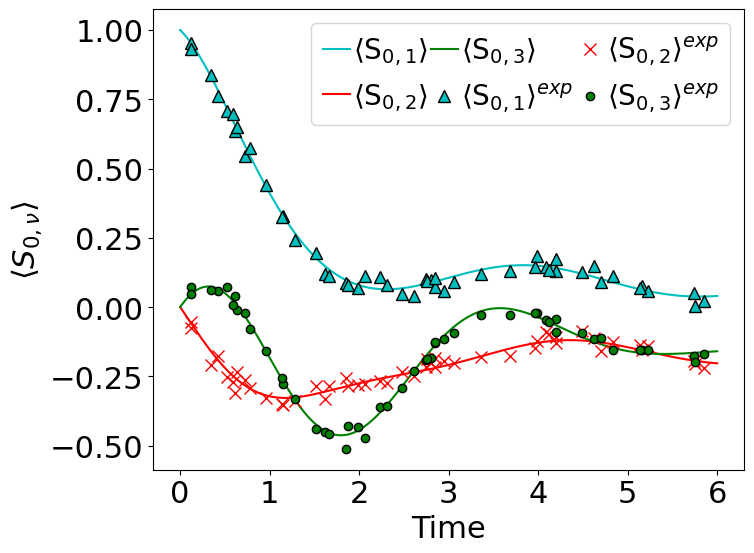

In [13]:
Js          = valor_real[4:].to_numpy()
dissipation = valor_real[:4].to_numpy()     

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
for i in range(3):
    plt.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{0,{i+1}}}$⟩")

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
valor_esperado_data_noisy = valor_esperado_data + random_data   

for i in range(3):
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{0,{i+1}}}$⟩$^{{exp}}$"
    }
    # Ajuste para markeredgecolor e markersize
    if marker == "x" or color == "r":
        pass  # Não adiciona markeredgecolor
    else:
        plot_kwargs["markeredgecolor"] = "k"
    if marker == "o":
        plot_kwargs["markersize"] = 6
    else:
        plot_kwargs["markersize"] = 8

    plt.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

Js = valor_previsto[4:].to_numpy()
dissipation = valor_previsto[:4].to_numpy()  

xticks_labels = ['0', '1', '2', '3', '4','5','6']

plt.ylabel(r'$\langle S_{0,\nu} \rangle$')
plt.xlabel('Time')
plt.xticks(np.linspace(0, N-1, len(xticks_labels)), xticks_labels)
plt.legend(fontsize=20, loc='best', frameon=True, ncol=3, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=1.)


plt.tight_layout()
plt.savefig("Predic_withfields_mu0.pdf", dpi=500, bbox_inches='tight')
plt.show()

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


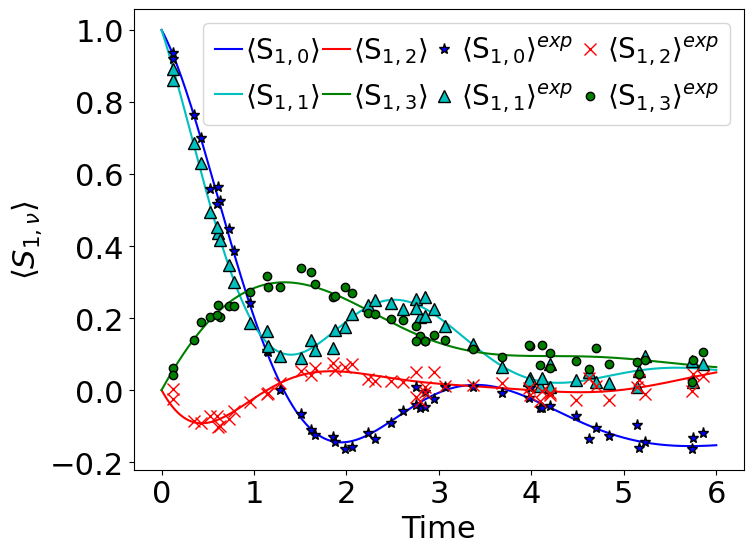

In [14]:
Js          = valor_real[4:].to_numpy()
dissipation = valor_real[:4].to_numpy()     

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
for idx, i in enumerate(range(3, 7)):
    plt.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{1,{idx}}}$⟩")

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
valor_esperado_data_noisy = valor_esperado_data + random_data   

for idx, i in enumerate(range(3, 7)):
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{1,{idx}}}$⟩$^{{exp}}$"
    }
    # Ajuste para markeredgecolor e markersize
    if marker == "x" or color == "r":
        pass  # Não adiciona markeredgecolor
    else:
        plot_kwargs["markeredgecolor"] = "k"
    if marker == "o":
        plot_kwargs["markersize"] = 6
    else:
        plot_kwargs["markersize"] = 8

    plt.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

Js = valor_previsto[4:].to_numpy()
dissipation = valor_previsto[:4].to_numpy()  

plt.ylabel(r'$\langle S_{1,\nu} \rangle$')
plt.xlabel('Time')
plt.xticks(np.linspace(0, N-1, len(xticks_labels)), xticks_labels)
plt.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=1.)


plt.tight_layout()
plt.savefig("Predic_withfields_mu1.pdf", dpi=500, bbox_inches='tight')
plt.show()

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


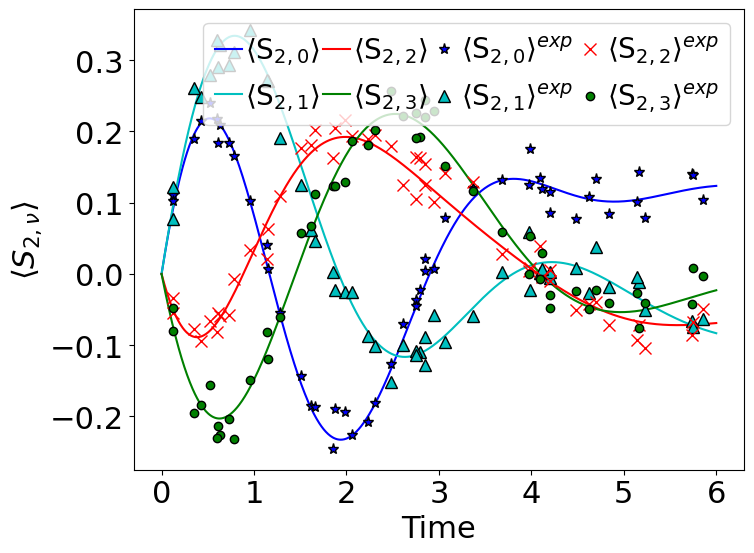

In [15]:
Js          = valor_real[4:].to_numpy()
dissipation = valor_real[:4].to_numpy()     

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
for idx, i in enumerate(range(7,11)):
    plt.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{2,{idx}}}$⟩")

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
valor_esperado_data_noisy = valor_esperado_data + random_data   

for idx, i in enumerate(range(7,11)):
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{2,{idx}}}$⟩$^{{exp}}$"
    }
    # Ajuste para markeredgecolor e markersize
    if marker == "x" or color == "r":
        pass  # Não adiciona markeredgecolor
    else:
        plot_kwargs["markeredgecolor"] = "k"
    if marker == "o":
        plot_kwargs["markersize"] = 6
    else:
        plot_kwargs["markersize"] = 8

    plt.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

Js = valor_previsto[4:].to_numpy()
dissipation = valor_previsto[:4].to_numpy()  

plt.ylabel(r'$\langle S_{2,\nu} \rangle$')
plt.xlabel('Time')
plt.xticks(np.linspace(0, N-1, len(xticks_labels)), xticks_labels)
plt.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=1.)

plt.tight_layout()
plt.savefig("Predic_withfields_mu2.pdf", bbox_inches='tight')
plt.show()

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


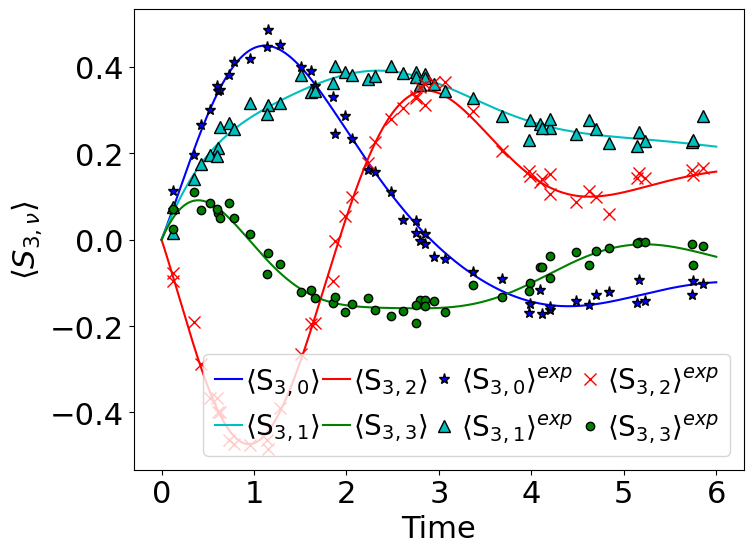

In [16]:
Js          = valor_real[4:].to_numpy()
dissipation = valor_real[:4].to_numpy()     

# Plot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)


for idx, i  in enumerate(range(11,15)):
    plt.plot(valor_esperado_data[:, i].cpu(), "-", color=colo[i % len(colo)], label=f"⟨S$_{{3,{idx}}}$⟩")

valor_esperado_data = data_qubit_two_crosstalk(Js, dissipation, tfinal, N, O_op)
random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
valor_esperado_data_noisy = valor_esperado_data + random_data   

for idx, i  in enumerate(range(11,15)):
    marker = markes[i % len(markes)]
    color = colo[i % len(colo)]
    plot_kwargs = {
        "linestyle": "",
        "color": color,
        "marker": marker,
        "label": f"⟨S$_{{3,{idx}}}$⟩$^{{exp}}$"
    }
    # Ajuste para markeredgecolor e markersize
    if marker == "x" or color == "r":
        pass  # Não adiciona markeredgecolor
    else:
        plot_kwargs["markeredgecolor"] = "k"
    if marker == "o":
        plot_kwargs["markersize"] = 6
    else:
        plot_kwargs["markersize"] = 8

    plt.plot(index_data, valor_esperado_data_noisy[index_data, i].cpu(), **plot_kwargs)

Js = valor_previsto[4:].to_numpy()
dissipation = valor_previsto[:4].to_numpy()  

plt.ylabel(r'$\langle S_{3,\nu} \rangle$')
plt.xlabel('Time')
plt.xticks(np.linspace(0, N-1, len(xticks_labels)), xticks_labels)
plt.legend(fontsize=20, loc='best', frameon=True, ncol=4, framealpha=0.8, handletextpad=0.1, columnspacing=.1, handlelength=1.)

plt.tight_layout()
plt.savefig("Predic_withfields_mu3.pdf", dpi=500, bbox_inches='tight')
plt.show()